In [12]:
!pip install pixellib

  Created wheel for imantics: filename=imantics-0.1.12-cp37-none-any.whl size=16038 sha256=d17687bdb21316d045a5bba3f58943d8b7bf5a5c79d12d4448ba12390b09561d
  Stored in directory: C:\Users\genaf\AppData\Local\pip\Cache\wheels\73\93\1c\9e2fc52eb74441941bc76cac441ddcc2c7ad67b18e1849e62a
Successfully built imantics


In [10]:
  def process_video_pascalvoc(self, video_path, overlay = False, frames_per_second = None, output_video_name = None):
    capture = cv2.VideoCapture(video_path)
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    if output_video_name is not None:
      save_video = cv2.VideoWriter(output_video_name, cv2.VideoWriter_fourcc(*'DIVX'),frames_per_second, (width, height))
    
    counter = 0
    start = time.time() 

    if overlay == True:
      while True:
        counter += 1
        
        ret, frame = capture.read()
        
        if ret:
          raw_labels, frame_overlay  = self.segmentAsPascalvoc(frame, overlay=True, process_frame= True)
          print("No. of frames:", counter)
          output = cv2.resize(frame_overlay, (width,height), interpolation=cv2.INTER_AREA)
          if output_video_name is not None:
            save_video.write(output)
        else:
          break   
 
      end = time.time()
      print(f"Processed {counter} frames in {end-start:.1f} seconds")
      capture.release()
      if output_video_name is not None:
        save_video.release()
      return  raw_labels, output

    else:
      while True:
        
        counter += 1
        ret, frame = capture.read()
        
        if ret:
          raw_labels, new_frame  = self.segmentAsPascalvoc(frame, process_frame= True)  
          print("No. of frames:", counter)
          output = cv2.resize(new_frame, (width,height), interpolation=cv2.INTER_AREA)
          if output_video_name is not None:
            save_video.write(output)

        else:
          break

      capture.release()

      end = time.time()
      print(f"Processed {counter} frames in {end-start:.1f} seconds")
      
      if frames_per_second is not None:
        save_video.release()

      return  raw_labels,  output

In [ ]:
  def load_pascalvoc_model(self, model_path):
    if model_file == "pb":
      self.graph = tf.Graph()

      graph_def = None

      with tf.compat.v1.gfile.GFile(model_path, 'rb')as file_handle:
        graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())

      if graph_def is None:
        raise RuntimeError('Cannot find inference graph')

      with self.graph.as_default():
        tf.graph_util.import_graph_def(graph_def, name='')

      self.sess = tf.compat.v1.Session(graph=self.graph)

    else:
      self.model.load_weights(model_path)


In [ ]:
  def segmentAsPascalvoc(self, image_path, process_frame = False, output_image_name=None,overlay=False,  verbose = None): 
    
    if model_file == "pb":

      if process_frame == True:
        image = image_path

      else:
        image = cv2.imread(image_path)

      w,h, n = image.shape

      image_overlay = image.copy()
     
      if n > 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

      resize_ratio = 1.0 * self.INPUT_SIZE / max(w, h)
      target_size = (int(resize_ratio * w), int(resize_ratio * h))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
      batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
     
      seg_image = batch_seg_map[0]
      raw_labels = seg_image
      
      """Access  the unique class ids of the masks """
      unique_labels = np.unique(raw_labels)
      
      raw_labels = np.array(Image.fromarray(raw_labels.astype('uint8')).resize((h, w)))
      
      
      """ Convert the indexed masks to boolean masks """
      raw_labels = np.ma.make_mask(raw_labels)
      segvalues = {"class_ids":unique_labels,  "masks":raw_labels}  
        
      #Apply segmentation color map
      labels = labelP_to_color_image(seg_image)   
      labels = np.array(Image.fromarray(labels.astype('uint8')).resize((h, w)))
      new_img = cv2.cvtColor(labels, cv2.COLOR_RGB2BGR)
      
      if overlay == True:
        alpha = 0.7
        cv2.addWeighted(new_img, alpha, image_overlay, 1 - alpha,0, image_overlay)

        if output_image_name is not None:
          cv2.imwrite(output_image_name, image_overlay)
          print("Processed Image saved successfully in your current working directory.")

        return segvalues, image_overlay

        
      else:  
        if output_image_name is not None:
  
          cv2.imwrite(output_image_name, new_img)

          print("Processed Image saved successfuly in your current working directory.")

        return segvalues, new_img 

      
    else:

      trained_image_width=512
      mean_subtraction_value=127.5

      if process_frame == True:
        image = image_path
      else:  
        image = np.array(Image.open(image_path))     
   

      # resize to max dimension of images from training dataset
      w, h, n = image.shape

      if n > 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGB)
    
      image_overlay = image.copy()

      ratio = float(trained_image_width) / np.max([w, h])
      resized_image = np.array(Image.fromarray(image.astype('uint8')).resize((int(ratio * h), int(ratio * w))))
      resized_image = (resized_image / mean_subtraction_value) -1


      # pad array to square image to match training images
      pad_x = int(trained_image_width - resized_image.shape[0])
      pad_y = int(trained_image_width - resized_image.shape[1])
      resized_image = np.pad(resized_image, ((0, pad_x), (0, pad_y), (0, 0)), mode='constant')

      if verbose is not None:
        print("Processing image....")

      #run prediction
      res = self.model.predict(np.expand_dims(resized_image, 0))
    
      labels = np.argmax(res.squeeze(), -1)
      # remove padding and resize back to original image
      if pad_x > 0:
        labels = labels[:-pad_x]
      if pad_y > 0:
        labels = labels[:, :-pad_y]

      raw_labels = labels
      
      """ Access the unique class ids of the masks"""
      unique_labels = np.unique(raw_labels)
      
      raw_labels = np.array(Image.fromarray(raw_labels.astype('uint8')).resize((h, w)))



      """ Convert the indexed masks to boolean  """
      raw_labels = np.ma.make_mask(raw_labels)

      segvalues = {"class_ids":unique_labels,  "masks":raw_labels}   

        
      #Apply segmentation color map
      labels = labelP_to_color_image(labels)   
      labels = np.array(Image.fromarray(labels.astype('uint8')).resize((h, w)))
      
      
      new_img = cv2.cvtColor(labels, cv2.COLOR_RGB2BGR)
      

      if overlay == True:
        alpha = 0.7
        cv2.addWeighted(new_img, alpha, image_overlay, 1 - alpha,0, image_overlay)

        if output_image_name is not None:
          cv2.imwrite(output_image_name, image_overlay)
          print("Processed Image saved successfully in your current working directory.")

        return segvalues, image_overlay

        
      else:  
        if output_image_name is not None:
  
          cv2.imwrite(output_image_name, new_img)

          print("Processed Image saved successfuly in your current working directory.")

        return segvalues, new_img 


In [8]:
###### ACTUAL CODE THAT WORKS

#testing for one image

import pixellib
from pixellib.semantic import semantic_segmentation

segment_image = semantic_segmentation()
segment_image.load_pascalvoc_model("deeplabv3_xception_tf_dim_ordering_tf_kernels.h5") 
segment_image.segmentAsPascalvoc("walking.jpg", output_image_name = "image_new.jpg")

Processed Image saved successfuly in your current working directory.


({'class_ids': array([ 0, 15], dtype=int64),
  'masks': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])},
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0]

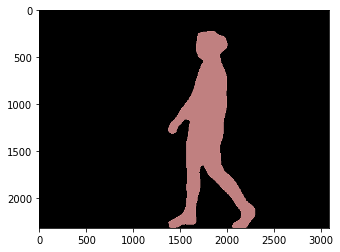

In [9]:
import matplotlib.pyplot as plt

img = plt.imread('image_new.jpg')
plt.imshow(img)

In [10]:
# taking each frame out from video
import cv2

vidcap = cv2.VideoCapture('gaitparkinsonstrimmedbackpainleft.mp4')
success,image = vidcap.read()
count = 0

while success:
    cv2.imwrite("frameparkinsons%d.jpg" % count, image) # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame:  True
Read a new frame

In [6]:
import pixellib
from pixellib.semantic import semantic_segmentation

segment_video = semantic_segmentation()
segment_video.load_pascalvoc_model("deeplabv3_xception_tf_dim_ordering_tf_kernels.h5")
segment_video.process_video_pascalvoc('gaitparkinsons_Trim.mp4', frames_per_second= 15, output_video_name="path_to_output_video.mp4")

No. of frames: 1
No. of frames: 2
No. of frames: 3
No. of frames: 4
No. of frames: 5
No. of frames: 6
No. of frames: 7
No. of frames: 8
No. of frames: 9
No. of frames: 10
No. of frames: 11
No. of frames: 12
No. of frames: 13
No. of frames: 14
No. of frames: 15
No. of frames: 16
No. of frames: 17
No. of frames: 18
No. of frames: 19
No. of frames: 20
No. of frames: 21
No. of frames: 22
No. of frames: 23
No. of frames: 24
No. of frames: 25
No. of frames: 26
No. of frames: 27
No. of frames: 28
No. of frames: 29
No. of frames: 30
No. of frames: 31
No. of frames: 32
No. of frames: 33
No. of frames: 34
No. of frames: 35
No. of frames: 36
No. of frames: 37
No. of frames: 38
No. of frames: 39
No. of frames: 40
No. of frames: 41
No. of frames: 42
No. of frames: 43
No. of frames: 44
No. of frames: 45
No. of frames: 46
No. of frames: 47
No. of frames: 48
No. of frames: 49
No. of frames: 50
No. of frames: 51
No. of frames: 52
No. of frames: 53
No. of frames: 54
No. of frames: 55
No. of frames: 56
N

({'class_ids': array([ 0, 15], dtype=int64),
  'masks': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])},
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0]

In [7]:
import pixellib
from pixellib.semantic import semantic_segmentation

segment_video = semantic_segmentation()
segment_video.load_pascalvoc_model("deeplabv3_xception_tf_dim_ordering_tf_kernels.h5")
segment_video.process_video_pascalvoc('gaitparkinsons_Trimback.mp4', frames_per_second= 15, output_video_name="gaitparkinsons_Trimbackhighlighted.mp4")

No. of frames: 1
No. of frames: 2
No. of frames: 3
No. of frames: 4
No. of frames: 5
No. of frames: 6
No. of frames: 7
No. of frames: 8
No. of frames: 9
No. of frames: 10
No. of frames: 11
No. of frames: 12
No. of frames: 13
No. of frames: 14
No. of frames: 15
No. of frames: 16
No. of frames: 17
No. of frames: 18
No. of frames: 19
No. of frames: 20
No. of frames: 21
No. of frames: 22
No. of frames: 23
No. of frames: 24
No. of frames: 25
No. of frames: 26
No. of frames: 27
No. of frames: 28
No. of frames: 29
No. of frames: 30
No. of frames: 31
No. of frames: 32
No. of frames: 33
No. of frames: 34
No. of frames: 35
No. of frames: 36
No. of frames: 37
No. of frames: 38
No. of frames: 39
No. of frames: 40
No. of frames: 41
No. of frames: 42
No. of frames: 43
No. of frames: 44
No. of frames: 45
No. of frames: 46
No. of frames: 47
No. of frames: 48
No. of frames: 49
No. of frames: 50
No. of frames: 51
No. of frames: 52
No. of frames: 53
No. of frames: 54
No. of frames: 55
No. of frames: 56
N

({'class_ids': array([ 0, 15], dtype=int64),
  'masks': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])},
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0]

In [8]:
import pixellib
from pixellib.semantic import semantic_segmentation

segment_video = semantic_segmentation()
segment_video.load_pascalvoc_model("deeplabv3_xception_tf_dim_ordering_tf_kernels.h5")
segment_video.process_video_pascalvoc('parkinsonsbackpaingait_Trim.mp4', frames_per_second= 15, output_video_name="gaitparkinsonstrimmedbackpain.mp4")

No. of frames: 1
No. of frames: 2
No. of frames: 3
No. of frames: 4
No. of frames: 5
No. of frames: 6
No. of frames: 7
No. of frames: 8
No. of frames: 9
No. of frames: 10
No. of frames: 11
No. of frames: 12
No. of frames: 13
No. of frames: 14
No. of frames: 15
No. of frames: 16
No. of frames: 17
No. of frames: 18
No. of frames: 19
No. of frames: 20
No. of frames: 21
No. of frames: 22
No. of frames: 23
No. of frames: 24
No. of frames: 25
No. of frames: 26
No. of frames: 27
No. of frames: 28
No. of frames: 29
No. of frames: 30
No. of frames: 31
No. of frames: 32
No. of frames: 33
No. of frames: 34
No. of frames: 35
No. of frames: 36
No. of frames: 37
No. of frames: 38
No. of frames: 39
No. of frames: 40
No. of frames: 41
No. of frames: 42
No. of frames: 43
No. of frames: 44
No. of frames: 45
No. of frames: 46
No. of frames: 47
No. of frames: 48
No. of frames: 49
No. of frames: 50
No. of frames: 51
No. of frames: 52
No. of frames: 53
No. of frames: 54
No. of frames: 55
No. of frames: 56
N

({'class_ids': array([ 0, 15], dtype=int64),
  'masks': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])},
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0]

In [9]:
import pixellib
from pixellib.semantic import semantic_segmentation

segment_video = semantic_segmentation()
segment_video.load_pascalvoc_model("deeplabv3_xception_tf_dim_ordering_tf_kernels.h5")
segment_video.process_video_pascalvoc('parkinsonsbackpaingaitleft_Trim.mp4', frames_per_second= 15, output_video_name="gaitparkinsonstrimmedbackpainleft.mp4")

No. of frames: 1
No. of frames: 2
No. of frames: 3
No. of frames: 4
No. of frames: 5
No. of frames: 6
No. of frames: 7
No. of frames: 8
No. of frames: 9
No. of frames: 10
No. of frames: 11
No. of frames: 12
No. of frames: 13
No. of frames: 14
No. of frames: 15
No. of frames: 16
No. of frames: 17
No. of frames: 18
No. of frames: 19
No. of frames: 20
No. of frames: 21
No. of frames: 22
No. of frames: 23
No. of frames: 24
No. of frames: 25
No. of frames: 26
No. of frames: 27
No. of frames: 28
No. of frames: 29
No. of frames: 30
No. of frames: 31
No. of frames: 32
No. of frames: 33
No. of frames: 34
No. of frames: 35
No. of frames: 36
No. of frames: 37
No. of frames: 38
No. of frames: 39
No. of frames: 40
No. of frames: 41
No. of frames: 42
No. of frames: 43
No. of frames: 44
No. of frames: 45
No. of frames: 46
No. of frames: 47
No. of frames: 48
No. of frames: 49
No. of frames: 50
No. of frames: 51
No. of frames: 52
No. of frames: 53
No. of frames: 54
No. of frames: 55
No. of frames: 56
N

No. of frames: 438
No. of frames: 439
No. of frames: 440
No. of frames: 441
No. of frames: 442
No. of frames: 443
No. of frames: 444
No. of frames: 445
No. of frames: 446
No. of frames: 447
No. of frames: 448
No. of frames: 449
No. of frames: 450
No. of frames: 451
No. of frames: 452
No. of frames: 453
No. of frames: 454
No. of frames: 455
No. of frames: 456
No. of frames: 457
No. of frames: 458
No. of frames: 459
No. of frames: 460
No. of frames: 461
No. of frames: 462
No. of frames: 463
No. of frames: 464
No. of frames: 465
No. of frames: 466
No. of frames: 467
No. of frames: 468
No. of frames: 469
No. of frames: 470
No. of frames: 471
No. of frames: 472
No. of frames: 473
No. of frames: 474
No. of frames: 475
No. of frames: 476
No. of frames: 477
No. of frames: 478
No. of frames: 479
No. of frames: 480
No. of frames: 481
No. of frames: 482
No. of frames: 483
No. of frames: 484
No. of frames: 485
No. of frames: 486
No. of frames: 487
No. of frames: 488
No. of frames: 489
No. of frame

({'class_ids': array([ 0, 15], dtype=int64),
  'masks': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]])},
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0]

TypeError: 'numpy.bool_' object is not iterable

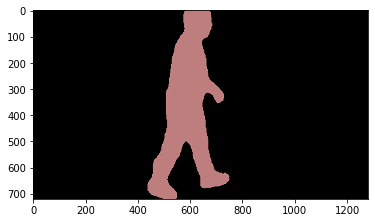

In [10]:
import matplotlib.pyplot as plt

img = plt.imread('segmentedframes/framesbackpainforward/frameparkinsons18.jpg')
plt.imshow(img)

In [1]:
from PIL import Image
import numpy as np

im = Image.open('segmentedframes/framesbackpainforward/frameparkinsons18.jpg')

# In this case, it's a 3-band (red, green, blue) image
# so we'll unpack the bands into 3 separate 2D arrays.
r, g, b = np.array(im).T

In [19]:
if 

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
